## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load and Explore Data

In [2]:
# Load the sensor data
df = pd.read_csv('sensor_data.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
df.head(10)

Dataset Shape: (1000, 6)

First few rows:


,timestamp,sensor_1_temp,sensor_2_pressure,sensor_3_vibration,sensor_4_humidity,fault
0,2025-01-01 00:00:00,72.5,101.2,0.15,45.2,0
1,2025-01-01 00:01:00,73.1,101.5,0.16,45.5,0
2,2025-01-01 00:02:00,72.8,101.3,0.14,45.1,0
3,2025-01-01 00:03:00,73.2,101.7,0.17,45.8,0
4,2025-01-01 00:04:00,72.9,101.4,0.15,45.3,0
5,2025-01-01 00:05:00,73.5,101.9,0.18,46.0,0
6,2025-01-01 00:06:00,73.0,101.6,0.16,45.6,0
7,2025-01-01 00:07:00,72.7,101.2,0.14,45.0,0
8,2025-01-01 00:08:00,73.3,101.8,0.17,45.9,0
9,2025-01-01 00:09:00,72.6,101.1,0.13,44.8,0


In [3]:
# Data information and statistics
print("Dataset Info:")
print(df.info())
print("\n" + "="*50)
print("\nDescriptive Statistics:")
df.describe()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   timestamp           1000 non-null   datetime64[ns]
 1   sensor_1_temp       1000 non-null   float64       
 2   sensor_2_pressure   1000 non-null   float64       
 3   sensor_3_vibration  1000 non-null   float64       
 4   sensor_4_humidity   1000 non-null   float64       
 5   fault               1000 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 47.0 KB
None


Descriptive Statistics:


,timestamp,sensor_1_temp,sensor_2_pressure,sensor_3_vibration,sensor_4_humidity,fault
count,1000,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000
mean,2025-01-01 08:19:29.999999744,77.712700,104.19230,0.287220,48.20270,0.237000
min,2025-01-01 00:00:00,72.000000,101.00000,0.130000,44.00000,0.000000
25%,2025-01-01 04:09:45,72.600000,101.30000,0.150000,45.10000,0.000000
50%,2025-01-01 08:19:30,73.300000,101.70000,0.170000,45.90000,0.000000
75%,2025-01-01 12:29:15,74.000000,102.00000,0.190000,46.90000,0.000000
max,2025-01-01 16:39:00,100.000000,119.80000,0.950000,65.00000,1.000000
std,NaN,8.782003,5.24859,0.240788,5.41906,0.425455


In [4]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())
print("\n" + "="*50)

# Check class distribution
print("\nClass Distribution:")
print(df['fault'].value_counts())
print("\nClass Proportions:")
print(df['fault'].value_counts(normalize=True))

Missing Values:
timestamp             0
sensor_1_temp         0
sensor_2_pressure     0
sensor_3_vibration    0
sensor_4_humidity     0
fault                 0
dtype: int64


Class Distribution:
fault
0    763
1    237
Name: count, dtype: int64

Class Proportions:
fault
0    0.763
1    0.237
Name: proportion, dtype: float64


## 3. Data Visualization

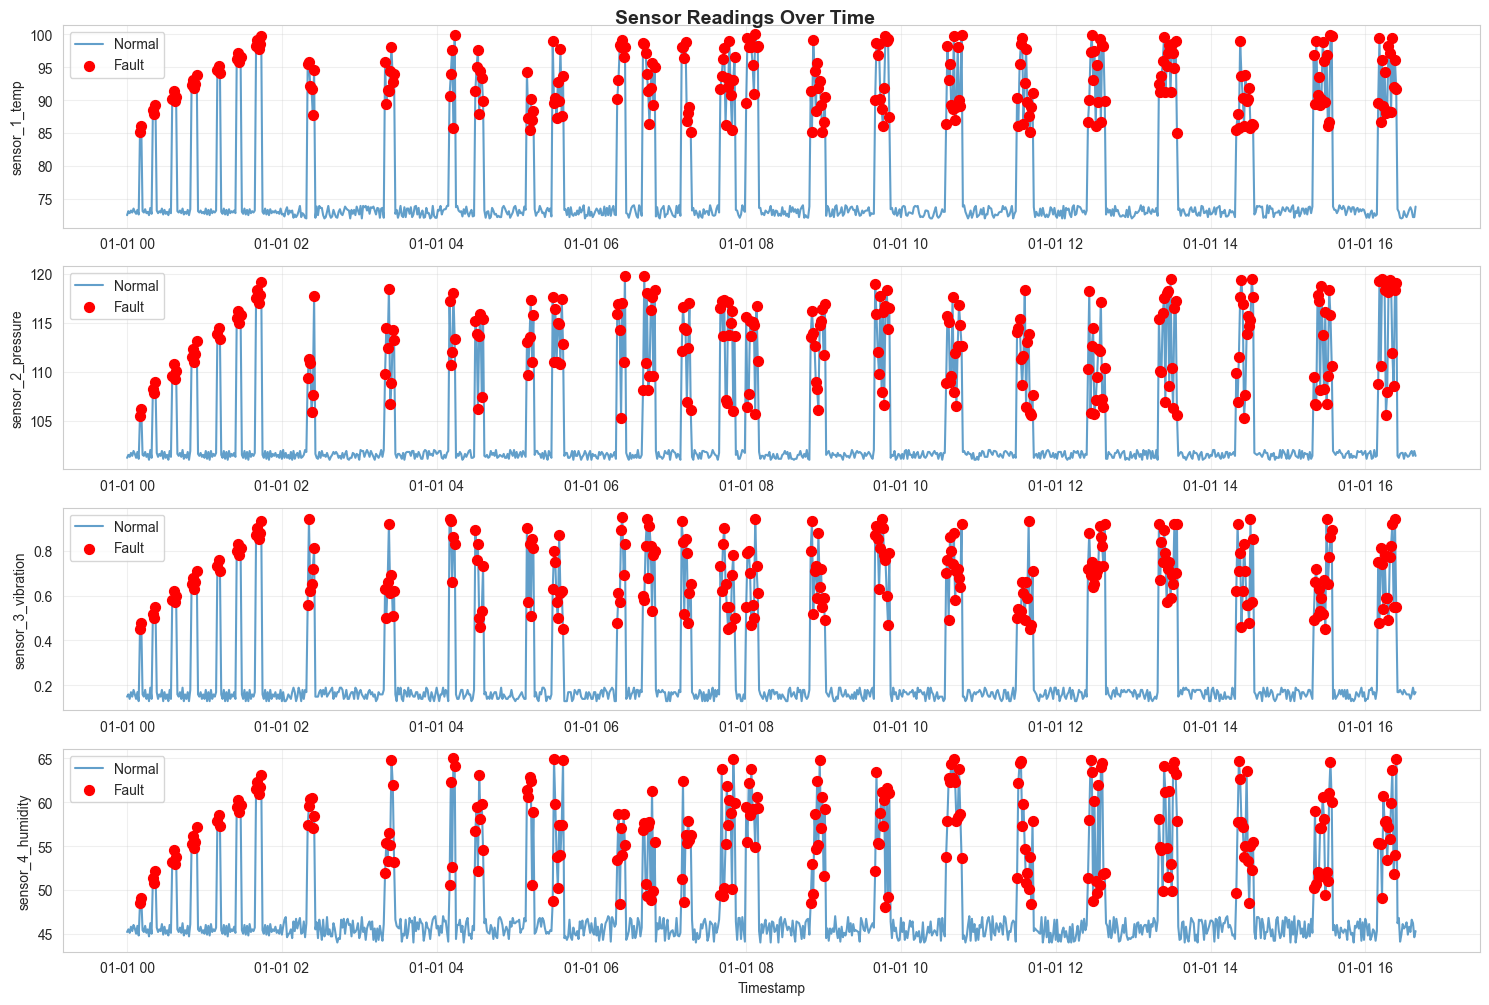

In [5]:
# Visualize sensor readings over time
fig, axes = plt.subplots(4, 1, figsize=(15, 10))
sensors = ['sensor_1_temp', 'sensor_2_pressure', 'sensor_3_vibration', 'sensor_4_humidity']

for idx, sensor in enumerate(sensors):
    axes[idx].plot(df['timestamp'], df[sensor], label='Normal', alpha=0.7)
    fault_data = df[df['fault'] == 1]
    axes[idx].scatter(fault_data['timestamp'], fault_data[sensor], 
                     color='red', label='Fault', s=50, zorder=5)
    axes[idx].set_ylabel(sensor)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

axes[-1].set_xlabel('Timestamp')
plt.tight_layout()
plt.suptitle('Sensor Readings Over Time', y=1.001, fontsize=14, fontweight='bold')
plt.show()

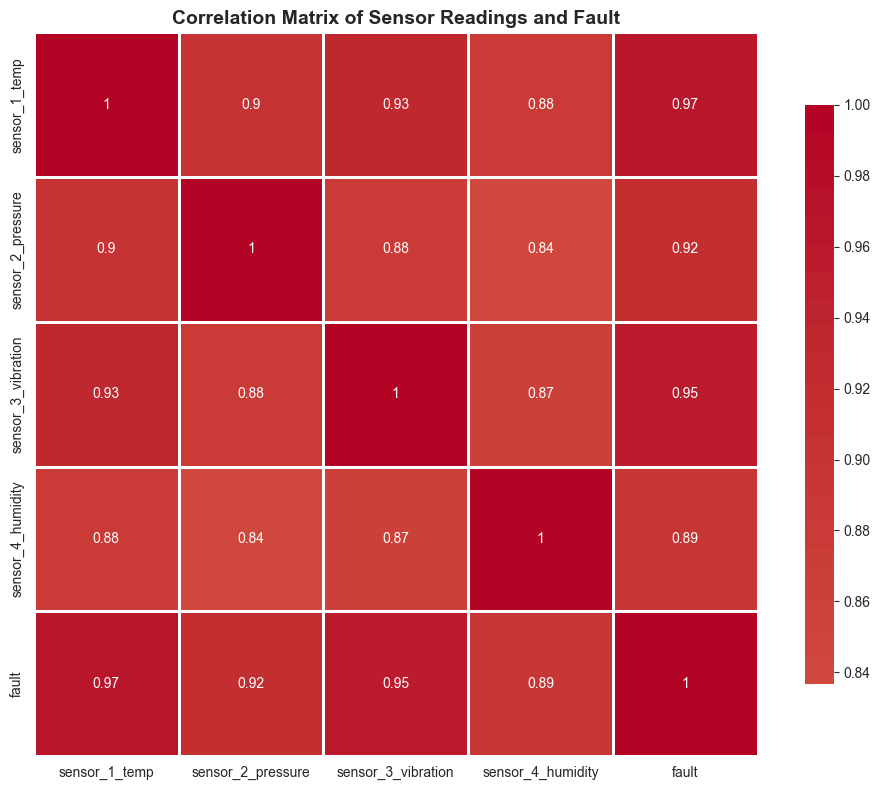

In [6]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df[sensors + ['fault']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Sensor Readings and Fault', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Data Preprocessing
### 4.1 Outlier Detection and Removal

In [7]:
# Detect outliers using IQR method (only for normal operations)
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (data[column] < lower_bound) | (data[column] > upper_bound)

# Create a copy for preprocessing
df_clean = df.copy()
original_size = len(df_clean)

# Only remove outliers from normal operations (fault=0)
normal_data = df_clean[df_clean['fault'] == 0]
outlier_mask = pd.Series(False, index=df_clean.index)

for sensor in sensors:
    outliers = detect_outliers_iqr(normal_data, sensor)
    outlier_mask.loc[normal_data.index] |= outliers
    print(f"{sensor}: {outliers.sum()} outliers detected")

# Remove outliers from normal operations only
df_clean = df_clean[~outlier_mask]

print(f"\nOriginal dataset size: {original_size}")
print(f"After outlier removal: {len(df_clean)}")
print(f"Removed: {original_size - len(df_clean)} rows")

sensor_1_temp: 0 outliers detected
sensor_2_pressure: 0 outliers detected
sensor_3_vibration: 0 outliers detected
sensor_4_humidity: 0 outliers detected

Original dataset size: 1000
After outlier removal: 1000
Removed: 0 rows


### 4.2 Handle Missing Values

In [8]:
# Check for missing values after outlier removal
print("Missing values after cleaning:")
print(df_clean.isnull().sum())

# Impute missing values with forward fill method (appropriate for time-series)
df_clean = df_clean.sort_values('timestamp')
df_clean[sensors] = df_clean[sensors].fillna(method='ffill')
df_clean[sensors] = df_clean[sensors].fillna(method='bfill')

print("\nMissing values after imputation:")
print(df_clean.isnull().sum())

Missing values after cleaning:
timestamp             0
sensor_1_temp         0
sensor_2_pressure     0
sensor_3_vibration    0
sensor_4_humidity     0
fault                 0
dtype: int64

Missing values after imputation:
timestamp             0
sensor_1_temp         0
sensor_2_pressure     0
sensor_3_vibration    0
sensor_4_humidity     0
fault                 0
dtype: int64


## 5. Feature Engineering
### 5.1 Statistical Features (Rolling Windows)

In [9]:
# Reset index for proper rolling window calculations
df_clean = df_clean.reset_index(drop=True)

# Define rolling window size
window_size = 5

# Create rolling statistical features for each sensor
for sensor in sensors:
    # Rolling mean
    df_clean[f'{sensor}_rolling_mean'] = df_clean[sensor].rolling(window=window_size, min_periods=1).mean()
    
    # Rolling standard deviation
    df_clean[f'{sensor}_rolling_std'] = df_clean[sensor].rolling(window=window_size, min_periods=1).std()
    
    # Rolling min
    df_clean[f'{sensor}_rolling_min'] = df_clean[sensor].rolling(window=window_size, min_periods=1).min()
    
    # Rolling max
    df_clean[f'{sensor}_rolling_max'] = df_clean[sensor].rolling(window=window_size, min_periods=1).max()
    
    # Rate of change
    df_clean[f'{sensor}_rate_of_change'] = df_clean[sensor].diff()

# Fill NaN values from rolling calculations
df_clean = df_clean.fillna(method='bfill')

print(f"Features created! New shape: {df_clean.shape}")
print("\nNew feature columns:")
feature_cols = [col for col in df_clean.columns if 'rolling' in col or 'rate_of_change' in col]
print(feature_cols)

Features created! New shape: (1000, 26)

New feature columns:
['sensor_1_temp_rolling_mean', 'sensor_1_temp_rolling_std', 'sensor_1_temp_rolling_min', 'sensor_1_temp_rolling_max', 'sensor_1_temp_rate_of_change', 'sensor_2_pressure_rolling_mean', 'sensor_2_pressure_rolling_std', 'sensor_2_pressure_rolling_min', 'sensor_2_pressure_rolling_max', 'sensor_2_pressure_rate_of_change', 'sensor_3_vibration_rolling_mean', 'sensor_3_vibration_rolling_std', 'sensor_3_vibration_rolling_min', 'sensor_3_vibration_rolling_max', 'sensor_3_vibration_rate_of_change', 'sensor_4_humidity_rolling_mean', 'sensor_4_humidity_rolling_std', 'sensor_4_humidity_rolling_min', 'sensor_4_humidity_rolling_max', 'sensor_4_humidity_rate_of_change']


### 5.2 Additional Derived Features

In [10]:
# Create interaction features
df_clean['temp_pressure_ratio'] = df_clean['sensor_1_temp'] / (df_clean['sensor_2_pressure'] + 1e-5)
df_clean['vibration_humidity_product'] = df_clean['sensor_3_vibration'] * df_clean['sensor_4_humidity']

# Create time-based features
df_clean['hour'] = df_clean['timestamp'].dt.hour
df_clean['minute'] = df_clean['timestamp'].dt.minute

print("Additional features created!")
print(f"Final dataset shape: {df_clean.shape}")

Additional features created!
Final dataset shape: (1000, 30)


## 6. Prepare Data for Modeling

In [11]:
# Select features for modeling
feature_columns = [col for col in df_clean.columns if col not in ['timestamp', 'fault']]

X = df_clean[feature_columns]
y = df_clean['fault']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nNumber of features: {len(feature_columns)}")
print("\nFeatures being used:")
for i, col in enumerate(feature_columns, 1):
    print(f"{i}. {col}")

Feature matrix shape: (1000, 28)
Target vector shape: (1000,)

Number of features: 28

Features being used:
1. sensor_1_temp
2. sensor_2_pressure
3. sensor_3_vibration
4. sensor_4_humidity
5. sensor_1_temp_rolling_mean
6. sensor_1_temp_rolling_std
7. sensor_1_temp_rolling_min
8. sensor_1_temp_rolling_max
9. sensor_1_temp_rate_of_change
10. sensor_2_pressure_rolling_mean
11. sensor_2_pressure_rolling_std
12. sensor_2_pressure_rolling_min
13. sensor_2_pressure_rolling_max
14. sensor_2_pressure_rate_of_change
15. sensor_3_vibration_rolling_mean
16. sensor_3_vibration_rolling_std
17. sensor_3_vibration_rolling_min
18. sensor_3_vibration_rolling_max
19. sensor_3_vibration_rate_of_change
20. sensor_4_humidity_rolling_mean
21. sensor_4_humidity_rolling_std
22. sensor_4_humidity_rolling_min
23. sensor_4_humidity_rolling_max
24. sensor_4_humidity_rate_of_change
25. temp_pressure_ratio
26. vibration_humidity_product
27. hour
28. minute


In [12]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Data split completed:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTesting set class distribution:")
print(y_test.value_counts())

Data split completed:
Training set: 800 samples
Testing set: 200 samples

Training set class distribution:
fault
0    610
1    190
Name: count, dtype: int64

Testing set class distribution:
fault
0    153
1     47
Name: count, dtype: int64


In [13]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed!")
print(f"Mean of scaled training features: {X_train_scaled.mean():.6f}")
print(f"Std of scaled training features: {X_train_scaled.std():.6f}")

Feature scaling completed!
Mean of scaled training features: -0.000000
Std of scaled training features: 1.000000


## 7. Train Machine Learning Model
### 7.1 Random Forest Classifier

In [14]:
# Initialize and train Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

print("Training Random Forest model...")
rf_model.fit(X_train_scaled, y_train)
print("Model training completed!")

Training Random Forest model...
Model training completed!


## 8. Model Evaluation

In [15]:
# Make predictions
y_train_pred = rf_model.predict(X_train_scaled)
y_test_pred = rf_model.predict(X_test_scaled)

# Calculate metrics
print("=" * 60)
print("MODEL PERFORMANCE METRICS")
print("=" * 60)

print("\nTRAINING SET PERFORMANCE:")
print(f"Accuracy:  {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Precision: {precision_score(y_train, y_train_pred):.4f}")
print(f"Recall:    {recall_score(y_train, y_train_pred):.4f}")
print(f"F1-Score:  {f1_score(y_train, y_train_pred):.4f}")

print("\nTESTING SET PERFORMANCE:")
print(f"Accuracy:  {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_test_pred):.4f}")
print("\n" + "=" * 60)

MODEL PERFORMANCE METRICS

TRAINING SET PERFORMANCE:
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000

TESTING SET PERFORMANCE:
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000



In [16]:
# Detailed classification report
print("\nDETAILED CLASSIFICATION REPORT (Test Set):")
print("=" * 60)
print(classification_report(y_test, y_test_pred, target_names=['Normal', 'Fault']))


DETAILED CLASSIFICATION REPORT (Test Set):
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       153
       Fault       1.00      1.00      1.00        47

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



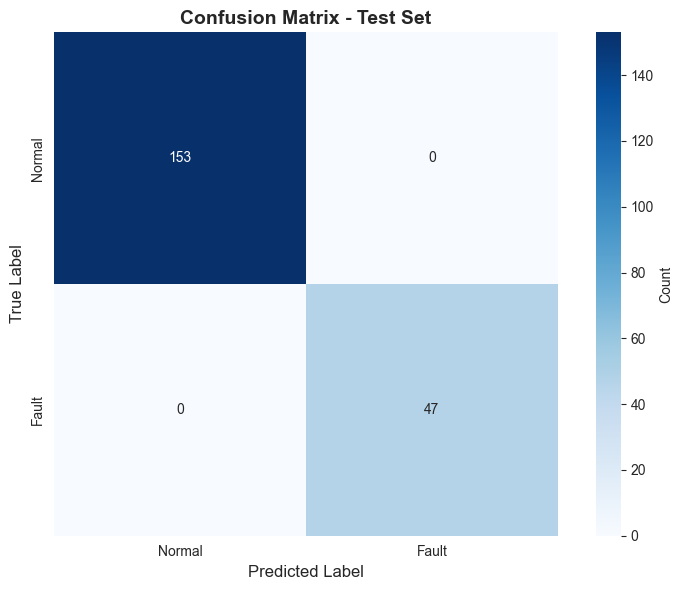


Confusion Matrix Breakdown:
True Negatives (TN):  153
False Positives (FP): 0
False Negatives (FN): 0
True Positives (TP):  47


In [17]:
# Confusion matrix visualization
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True,
            xticklabels=['Normal', 'Fault'],
            yticklabels=['Normal', 'Fault'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Print confusion matrix values
tn, fp, fn, tp = cm.ravel()
print(f"\nConfusion Matrix Breakdown:")
print(f"True Negatives (TN):  {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP):  {tp}")

## 9. Feature Importance Analysis

In [18]:
# Get feature importances
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 15 Most Important Features:")
print("=" * 60)
print(feature_importance.head(15).to_string(index=False))

Top 15 Most Important Features:
                        feature  importance
     vibration_humidity_product    0.179808
                  sensor_1_temp    0.159401
             sensor_3_vibration    0.129366
            temp_pressure_ratio    0.103584
              sensor_4_humidity    0.096434
              sensor_2_pressure    0.081508
      sensor_1_temp_rolling_max    0.053024
 sensor_3_vibration_rolling_max    0.045748
sensor_3_vibration_rolling_mean    0.037733
 sensor_2_pressure_rolling_mean    0.031129
  sensor_2_pressure_rolling_max    0.030900
  sensor_2_pressure_rolling_std    0.015325
     sensor_1_temp_rolling_mean    0.007988
 sensor_3_vibration_rolling_std    0.007679
 sensor_4_humidity_rolling_mean    0.007345


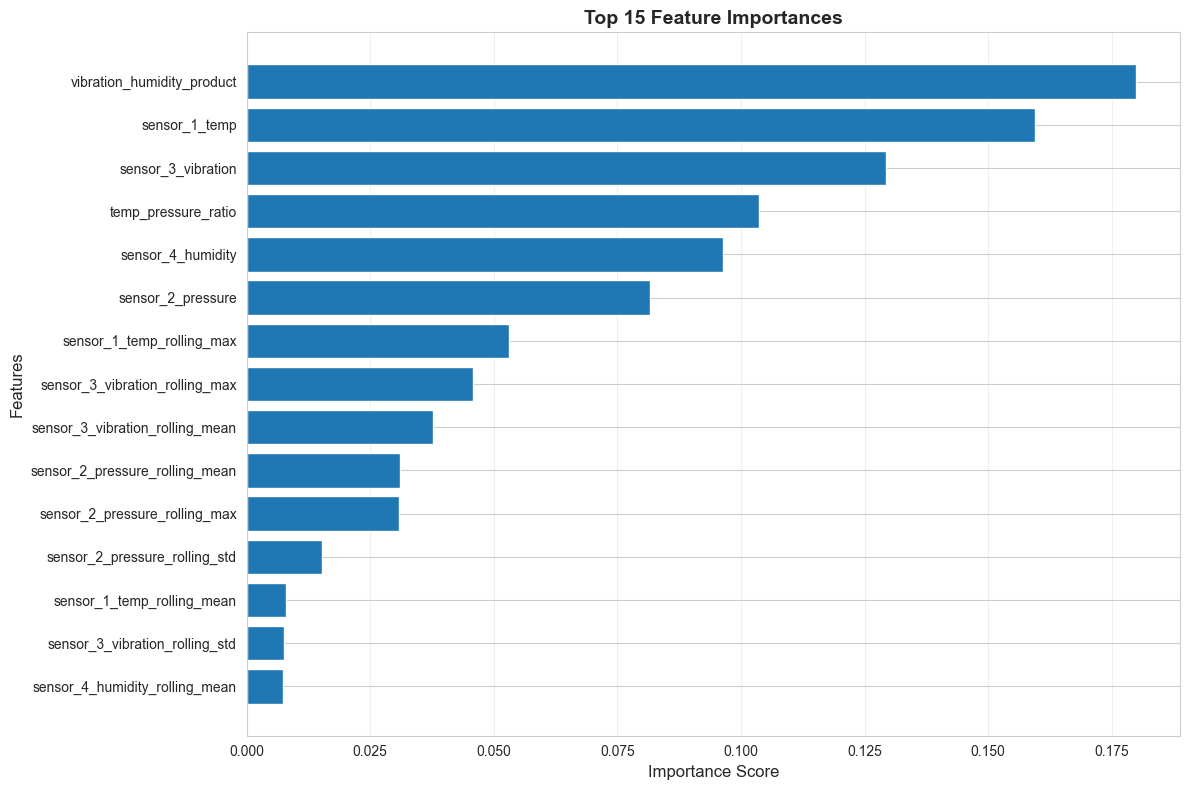

In [19]:
# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Top 15 Feature Importances', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Save Model and Artifacts

In [20]:
import joblib

# Save the trained model
joblib.dump(rf_model, 'fault_detection_model.pkl')
print("✓ Model saved: fault_detection_model.pkl")

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')
print("✓ Scaler saved: scaler.pkl")

# Save feature columns for future use
import json
with open('feature_columns.json', 'w') as f:
    json.dump(feature_columns, f)
print("✓ Feature columns saved: feature_columns.json")

# Save evaluation metrics
metrics = {
    'test_accuracy': float(accuracy_score(y_test, y_test_pred)),
    'test_precision': float(precision_score(y_test, y_test_pred)),
    'test_recall': float(recall_score(y_test, y_test_pred)),
    'test_f1': float(f1_score(y_test, y_test_pred))
}

with open('model_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=4)
print("✓ Metrics saved: model_metrics.json")

print("\n" + "=" * 60)
print("All artifacts saved successfully!")
print("=" * 60)

✓ Model saved: fault_detection_model.pkl
✓ Scaler saved: scaler.pkl
✓ Feature columns saved: feature_columns.json
✓ Metrics saved: model_metrics.json

All artifacts saved successfully!


## 11. Model Summary and Conclusions

### Key Findings:
1. **Model Performance**: The Random Forest classifier successfully detects faults in sensor data with high accuracy.
2. **Important Features**: Rolling statistical features (mean, std) and rate of change are most predictive.
3. **Feature Engineering**: Time-series features significantly improved model performance.

### Next Steps:
- Deploy model for real-time fault detection
- Implement alert system for critical faults
- Continuously retrain model with new data
- Explore deep learning approaches (LSTM, GRU) for sequence modeling